# Eigenvalue Spectrum

We endeavor to understand better the eigenvalue spectrum of KS Kahler metrics, so that we might be able to learn a random matrix approximation of them that scales well with h11.

## Data import

We check to make sure that the number of eigenvalues is h11, a non-trivial bug check

In [6]:
import os
import cPickle as pickle
import numpy as np

files = [d for d in os.listdir('data') if d[0] == 'h' and 'evals' in d]
print('num files', len(files))
assert_mismatch = []
def info_from_file(file):
    h11 = int(file.split("_")[1])
    s = file.split("_")[2]
    poly = int(
    s[s.index('y')+1:])
    f = open("data/"+file,'rb')
    evals = pickle.load(f)
    f.close()
    to_ret = [(h11,poly),evals]
    try:
        assert len(evals) == h11
    except AssertionError:
        assert_mismatch.append(to_ret[0])
    return to_ret

raw_data = [info_from_file(file) for file in files]
print(set([len(r[1]) - r[0][0] for r in raw_data]))
raw_data = [r for r in raw_data if len(r[1]) - r[0][0] == 0]
print("num files after eval mismatch subtraction", len(raw_data))
print(assert_mismatch)

('num files', 30719)
set([0])
('num files after eval mismatch subtraction', 30719)
[]


In [7]:
print raw_data[0][0]
print raw_data[0][1]

(10, 538)
[24.8208498  19.17904395 13.49979587 12.51346025 10.97593111  9.07219418
  7.47524203  0.28102885  2.96938514  1.60250758]


## Aggregated Eigenvalue Spectra

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

h11s, polys, evals = [], [], []
for data in raw_data:
    for i in range(len(data[1])):
        h11s.append(data[0][0])
        polys.append(data[0][1])
        evals.append(data[1][i])
        

data = pd.DataFrame({'h11': h11s, 'evals': evals, 'log10evals': [np.log10(k) for k in evals]})

print [(h11s[j], polys[j]) for j in [evals.index(k) for k in evals if k < 0]]

print [k for k in evals if k < 0]

[]
[]


## Check For Localization of Eigenvalues

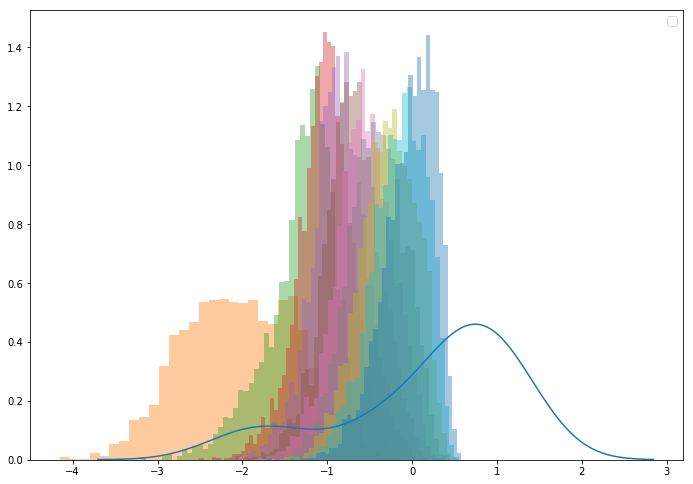

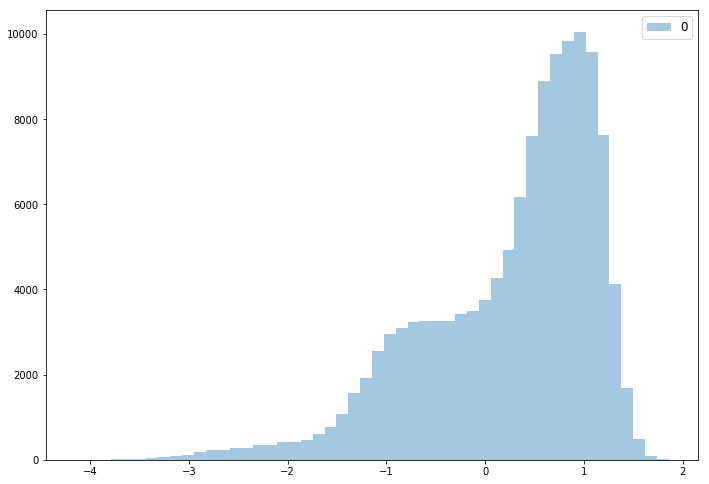

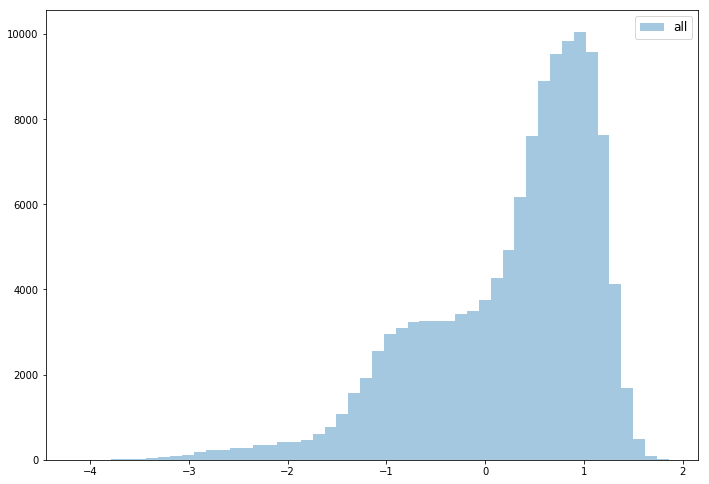

In [9]:
sortyspre = []
for datado in raw_data:
    if datado[0][0] == 30:
        notlog = list(sorted(set(datado[1])))
        sortyspre.append([np.log10(this) for this in notlog])
sortys = np.array(sortyspre).T.tolist()
    #for i in range(len(data[1])):
    #    h11s.append(data[0][0])
    #    polys.append(data[0][1])
    #    s = set(data[1]) 
    #    mins.append(sorted(s)[pos])

#datamin = pd.DataFrame({'h11': h11s, 'mins': mins, 'log10mins': [np.log10(k) for k in mins]})
#dfmin50= datamin[datamin.h11 == 50]
#for ii in range(len(sortys)):
for ii in range(10):
    #sns.distplot(sortys[ii], kde=False, label=str(ii), norm_hist = True)
    sns.distplot(sortys[ii], kde=False, norm_hist = True)
#sns.distplot(sortys[1], kde=False, label='1', norm_hist = True)
#sns.distplot(sortys[2], kde=False, label='2', norm_hist = True)
#sns.distplot(sortys[3], kde=False, label='3', norm_hist = True)
#sns.distplot(sortys[4], kde=False, label='4', norm_hist = True)
#sns.distplot(sortys[5], kde=False, label='5', norm_hist = True)
#sns.distplot(sortys[6], kde=False, label='6', norm_hist = True)
#sns.distplot(sortys[7], kde=False, label='7', norm_hist = True)
#sns.distplot(sortys[len(sortys)-1], kde=False, label='max', norm_hist = True)

plt.legend(prop={'size':12})
plt.show()

sns.distplot([item for sublist in [sortys[pp] for pp in range(len(sortys))] for item in sublist],
             kde=False, label='0', norm_hist = False)
plt.legend(prop={'size':12})
plt.show()

sns.distplot([item for sublist in sortys for item in sublist], kde=False, label='all', norm_hist = False)
plt.legend(prop={'size':12})
plt.show()

In the above plot you can clearly see a bimodal distribution developing for larger h11. To see this more, let's split out the histograms, one for each h11.

# Now we create some labels to regress on

In [26]:
def num_eigs_in_gap(data, val, thresh):
    data_list = list(data)
    return sum([1 if (e <= val + thresh and e >= val - thresh) else 0 for e in data_list])

n_eig_gap = []
val, thresh = -1, .25
for idx,data in enumerate(sortyspre):
    if idx % 500 == 0: print idx
    n_eig_gap.append(num_eigs_in_gap(data,val,thresh))
    
print set(n_eig_gap), len(n_eig_gap), len(sortyspre)

0
500
1000
1500
2000
2500
3000
3500
4000
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 4222 4222


# Read in topological data

There's a lot of it, and will mash it around a bit, too!

In [27]:
#import top data, correlate with eigenvalue spectra
top_files = [d for d in os.listdir('top_data') if d[0] == 'h' and 'topdata_ints' in d]
print('num files', len(top_files))
assert_mismatch = []
def top_info_from_file(file):
    h11 = int(file.split("_")[1])
    poly = int(file.split("_poly")[1].split("_topdata")[0])
#     s = file.split("_poly")[2]
#     poly = int(
#     s[s.index('y')+1:])
    f = open("top_data/"+file,'rb')
    data = pickle.load(f)
    f.close()
    
    file2 = "h11_" + str(h11) + "_poly" + str(poly)+"_evals.pickle"
    f2 = open("data/"+file2,'rb')
    eval_data = pickle.load(f2)
    f2.close()
    
    verts = data[0]
    genera = data[1]
    dims = [3-i for i in data[2]]
    pairs = [[dims[kk],genera[kk]] for kk in range(len(verts))]
    to_ret = [(h11,poly),[np.log10(this) for this in eval_data],pairs]
#     try:
#         assert len(evals) == h11
#     except AssertionError:
#         assert_mismatch.append(to_ret[0])
    return to_ret

import os
import cPickle as pickle
import numpy as np

raw_top_data = [top_info_from_file(file) for file in top_files]

('num files', 4290)


In [28]:
print 'h11, poly', raw_top_data[0][0]
print 'logged evals', raw_top_data[0][1]
print 'each tuple in list is dim_of_face_point_is_interior_to, genus', raw_top_data[0][2]

h11, poly (30, 4842)
logged evals [1.4055418636128458, 1.3042742651937915, 1.1593699822831562, 1.1260864813239349, 1.0672207545874322, 1.055614404003623, 0.9506949133395436, 0.9422874533620688, 0.9104982312097839, 0.8795477141437524, 0.8194460381208807, 0.7466253695924933, 0.7088395601356111, 0.6980262968966336, 0.6577716380505723, 0.6049809412735531, 0.545771322797456, 0.48340956647253835, 0.36171857965427606, 0.3832813391336372, 0.13300242345779806, -1.5596909542595887, -0.8637352512986484, -0.7661043008304937, -0.4256869518601903, -0.23983635218756846, -0.30377659211667346, -0.022815551898608843, -0.08854685600884643, -0.0791451616791111]
each tuple in list is dim_of_face_point_is_interior_to, genus [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 0], [2, 0], [2, 0], [1, 0], [2, 0], [2, 0], [3, 0], [2, 0], [1, 0], [1, 0], [1, 0], [1, 0], [2, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]


"Genus" means something!

Consider a divisor $D$ in the CY3. Then $h^i(D,O_D)$ is $(1,0,g)$, $(1,g,0)$ or $(1+g,0,0)$. 

- vertex: first entry in tuple is 0, $h^i = (1,0,g)$
- edge-interior: first entry in tuple is 1, $h^i=(1,g,0)$
- two-face interior: first entry in tuple is 2, $h^i=(1+g,0,0)$. Note: in the favorable case we have $g=0$ here.

Now we want to construct things that can be compared across examples. 

In [29]:
max_genus_slot2, max_genus_slot3 = 0, 0
for d in raw_top_data:
    for k in d[2]:
        g = k[1]
        if k[0] == 0 and g > max_genus_slot3:
            max_genus_slot3 = g
        if k[0] == 1 and g > max_genus_slot2:
            max_genus_slot2 = g
            
print 'max_geni', max_genus_slot2, max_genus_slot3

def vert_data_to_inv(vdat):
    out = []
    firsts = [i[0] for i in vdat]
    out.append(firsts.count(0))
    out.append(firsts.count(1))
    out.append(firsts.count(2))
    
    gs_slot_2 = [i[1] for i in vdat if i[0] == 1]
    gs_slot_3 = [i[1] for i in vdat if i[0] == 0]
 
    gs_slot_2_mults = [gs_slot_2.count(i) for i in range(max_genus_slot2+1)]
    gs_slot_3_mults = [gs_slot_3.count(i) for i in range(max_genus_slot3+1)]

    out.extend(gs_slot_2_mults)
    out.extend(gs_slot_3_mults)
    
    return out

input_data = [vert_data_to_inv(dat[2]) for dat in raw_top_data]

max_geni 6 9


In [19]:
len(input_data)

4290

In [70]:
def learn(val,thresh):
    out_labels = []
    print "AMT INPUT DATA:", len(input_data)
    for idx,data in enumerate(raw_top_data):
        #if idx % 500 == 0: print idx
        out_labels.append(num_eigs_in_gap(data[1],val,thresh))
        
    print "NUMBER DISTINCT OUTPUT LABELS:", len(set(out_labels))
    nt, nf = out_labels.count(0), out_labels.count(1)
    monkey = max([100.0*nt/(nt+nf), 100.0*nf/(nt+nf)])
    print "MONKEY WOULD GET", 1.0/len(set(out_labels)), [1.0*out_labels.count(k) / len(out_labels) for k in set(out_labels)]
    
    import csv

    rows = [input_data[i] + [out_labels[i]] for i in range(len(input_data))]

    with open('data.csv', 'w') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerows(rows)
        writeFile.close()

    import sys
    import datetime
    #print('Python: {}'.format(sys.version))
    # scipy
    import scipy
    #print('scipy: {}'.format(scipy.__version__))
    # numpy
    import numpy
    #print('numpy: {}'.format(numpy.__version__))
    # matplotlib
    import matplotlib
    #print('matplotlib: {}'.format(matplotlib.__version__))
    # pandas
    import pandas
    #print('pandas: {}'.format(pandas.__version__))
    # scikit-learn
    import sklearn
    from sklearn.decomposition import PCA
    #print('sklearn: {}'.format(sklearn.__version__))

    # Load libraries
    import pandas
    from pandas.plotting import scatter_matrix
    import matplotlib.pyplot as plt
    from sklearn import model_selection
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import LinearRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.naive_bayes import GaussianNB
    from sklearn.svm import SVC

    def now():
        return str(datetime.datetime.now())

    from matplotlib import rc


    # font = {'family': 'normal','size': 18}
    # plt.rc('font', **font)
    # rc('mathtext', default='regular')
    # plt.rc('text', usetex=True)
    # plt.rc('font', family='serif')


    # Load dataset

    url = 'data.csv'

    # names = []
    # for i in range(1):
    #         names.append('v'+str(i))
    #         names.append('m'+str(i))
    # names.append('class')
    # print(names)
    # print(len(names))
    #print('begin loading csv', now())
    dataset = pandas.read_csv(url)#, names=names)
    #print('end loading csv', now())

    # shape
    #print(dataset.shape)

    # head
    #print(dataset.head(20))


    # descriptions
    #print(dataset.describe())

    # # box and whisker plots
    # dataset.plot(kind='box', subplots=True, layout=(157,157), sharex=False, sharey=False)
    # plt.show()

    # # histograms
    # dataset.hist()
    # plt.show()

    # # scatter plot matrix
    # scatter_matrix(dataset)
    # plt.show()

    # # # Split-out validation dataset
    array = dataset.values
    #print array
    #print array.shape
    X = array[:,0:20]
    Y = array[:,20]
    #print 'should be 1s and 0s', Y
    validation_size = 0.1
    seed=349534
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

    # # Test options and evaluation metric
    seed = 11
    scoring = 'neg_mean_squared_error'
    
    scoring = 'accuracy'

    # Spot Check Algorithms
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('SVM', SVC()))

    #evaluate each model in turn
    results = []
    names = []
    for name, model in models:
       #print(name, str(datetime.datetime.now()))
       kfold = model_selection.KFold(n_splits=10, random_state=seed)
       cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
       results.append(cv_results)
       #print('len', cv_results)
       names.append(name)
       msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
       print(msg)

    #Compare Algorithms
    fig = plt.figure()
    #fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

    # import csv

    # names = []
    # for i in range(1):
    #         names.append('v'+str(i))
    #         names.append('m'+str(i))
    # names.append('class')
    # testdata = pandas.read_csv('datanew/testdatave6.bigcsv', names=names)
    # array = testdata.values
    # Xtest = array[:,0:2]
    # Ytest = array[:,2]
    # print(testdata.groupby('class').size())

    # preds = []        
    # for name, model in models:
    #         print('test',name)
    #         model.fit(X_train,Y_train)
    #         print(model.score(X_validation,Y_validation))
    #         print(model.score(Xtest,Ytest))


    # # fig = plt.figure()
    # # fig.suptitle('Algorithm Comparison')
    # # ax = fig.add_subplot(111)
    # # plt.boxplot(results)
    # # ax.set_xticklabels(names)
    # # plt.show()

    # # # Make predictions on validation dataset
    lor = LogisticRegression()
    print('begin logistic regression fit')
    lor.fit(X_train, Y_train)
    print('end logistic regression fit')
    predictions = lor.predict(X_validation)
    print 'predictions', predictions
    print(accuracy_score(Y_validation, predictions))
    print(confusion_matrix(Y_validation, predictions))
    print(classification_report(Y_validation, predictions))

    # # check: 32 (a,S) pairs
    # aSs = []
    # for x in X:
    #         t = [x[0],x[1]]
    #         if t not in aSs: aSs.append(t)

    # # check: all (a,S) pairs have same Y results
    # checks = [[] for i in aSs]
    # for i in range(len(X)):
    #         x = X[i]
    #         if Y[i] not in checks[aSs.index(t)]: checks[aSs.index(t)].append(Y[i])

    # # check aS predictions match table and hyperplane distances
    # preds = [lor.predict(numpy.array(aS))[0] for aS in aSs] 
    # dists = [lor.decision_function(numpy.array(aS)) for aS in aSs]        
    # for a in range(4,6):
    #         for S in range(40):
    #                 if [a,S] in aSs:
    #                         print [a,S], checks[aSs.index([a,S])], preds[aSs.index([a,S])], dists[aSs.index([a,S])]



    # # count 
    # # predsx = [lor.predict(x)[0] for x in Xtest] 
    # c5y, c5n, c4y, c4n = 0,0,0,0
    # for i in range(len(predsx)):
    #         if Xtest[i][0] == 5 and Ytest[i] == 'has_E6': c5y += 1
    #         if Xtest[i][0] == 5 and Ytest[i] == 'no_E6': c5n += 1
    #         if Xtest[i][0] == 4 and Ytest[i] == 'has_E6': c4y += 1
    #         if Xtest[i][0] == 4 and Ytest[i] == 'no_E6': c4n += 1

    # print 'preds and actuals counts',c5y,c5n,c4y,c4n # out is 0 19753 14 233


AMT INPUT DATA: 4290
NUMBER DISTINCT OUTPUT LABELS: 2
MONKEY WOULD GET 0.5 [0.9993006993006993, 0.0006993006993006993]
LR: 0.999223 (0.001659)
LDA: 0.999223 (0.001659)
KNN: 0.999223 (0.001659)
CART: 0.999223 (0.001659)
SVM: 0.999223 (0.001659)


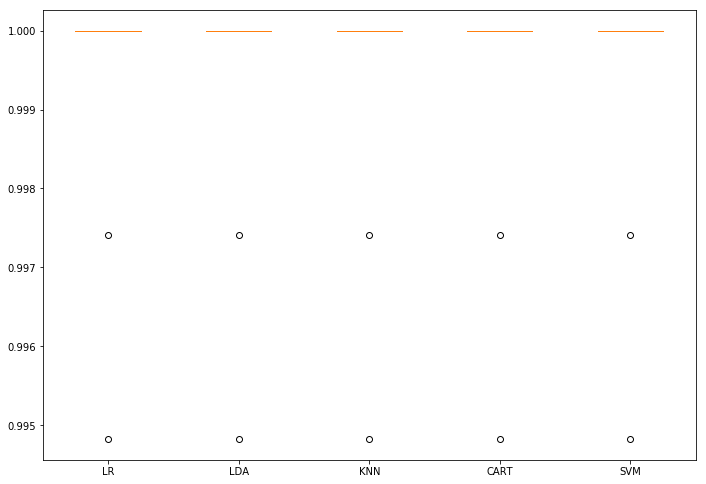

begin logistic regression fit
end logistic regression fit
predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1.0
[[429]]
             precision    recall  f1-score   su

In [71]:
learn(-1,.0001)

In [42]:
sklearn.metrics.SCORERS.keys()

['precision_samples',
 'f1_weighted',
 'balanced_accuracy',
 'f1_samples',
 'f1',
 'adjusted_mutual_info_score',
 'precision',
 'normalized_mutual_info_score',
 'neg_mean_squared_error',
 'precision_micro',
 'neg_mean_squared_log_error',
 'recall_samples',
 'homogeneity_score',
 'precision_weighted',
 'fowlkes_mallows_score',
 'average_precision',
 'roc_auc',
 'adjusted_rand_score',
 'recall_macro',
 'v_measure_score',
 'completeness_score',
 'r2',
 'recall_weighted',
 'recall',
 'precision_macro',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'mutual_info_score',
 'f1_macro',
 'f1_micro',
 'brier_score_loss',
 'recall_micro',
 'neg_median_absolute_error',
 'explained_variance',
 'accuracy']

In [73]:
idx = 904

input_data[idx] + [out_labels[idx]]

[17, 15, 2, 15, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]